In [ ]:
# Hui (Henry) Chen
# CSCI 415 - M01/ Fall 2020
# Project Part III
# Airbnb Open Data (NYC)

In [81]:
# config matplotlib display
%matplotlib notebook
import warnings

# make jupyter notebook display full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [144]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import norm
from scipy import stats

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

In [59]:
# hide the warning
warnings.filterwarnings('ignore')

# config matplotlib style
plt.style.use('seaborn')

# initial val
DATASET_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/visualisations/listings.csv"
DATASET = ""
DATASET_LOCAL = "./dataset/listings.csv"

In [3]:
def getDataSet():
    global DATASET

    # get the dataset file name
    fields = DATASET_URL.split("/")
    DATASET = str(fields[-1:][0])
    
    # download the dataset from the URL
    r = requests.get(DATASET_URL, allow_redirects=True)
    open(DATASET, 'wb').write(r.content)

In [4]:
# download the dataset remotely
# getDataSet()

df = pd.read_csv(DATASET_LOCAL)

In [5]:
df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,175,3,48,2019-11-04,0.36,2,365
1,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...",4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,76,1,354,2020-09-20,4.82,1,2
2,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,29,50,2019-12-02,0.36,1,2
3,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66120,-73.99423,Entire home/apt,175,7,1,2014-01-02,0.01,1,359
4,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,73,2,473,2020-03-15,3.40,1,350
5,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,75,2,118,2017-07-21,0.87,1,0
6,5552,Spacious river view in the West Village,8380,Maria,Manhattan,West Village,40.73552,-74.01042,Entire home/apt,160,3,66,2019-08-10,0.48,1,125
7,5803,"Lovely Room 1, Garden, Best Area, Legal rental",9744,Laurie,Brooklyn,South Slope,40.66829,-73.98779,Private room,82,4,181,2020-09-09,1.30,3,0
8,6021,Wonderful Guest Bedroom in Manhattan CENTRAL PARK,11528,Claudio,Manhattan,Upper West Side,40.79826,-73.96113,Private room,85,2,123,2019-12-09,0.89,1,365
9,6848,Only 2 stops to Manhattan studio,15991,Allen & Irina,Brooklyn,Williamsburg,40.70837,-73.95352,Entire home/apt,109,30,181,2020-03-16,1.31,1,0


### Analysis
Based on the info of the dataset, we can see that price can be compared with various features such as root_typ, number of reviews per month, and neighbourhood group.

In [7]:
def Draw_RoomType_vs_price():
    plt.figure(figsize=(9, 6))
    plt.scatter(x=df['room_type'], y=df['price'])

    plt.title("Room Type vs Price",size=15, weight='bold')
    plt.xlabel("Room Type", size=12)
    plt.ylabel("Price", size=12)
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


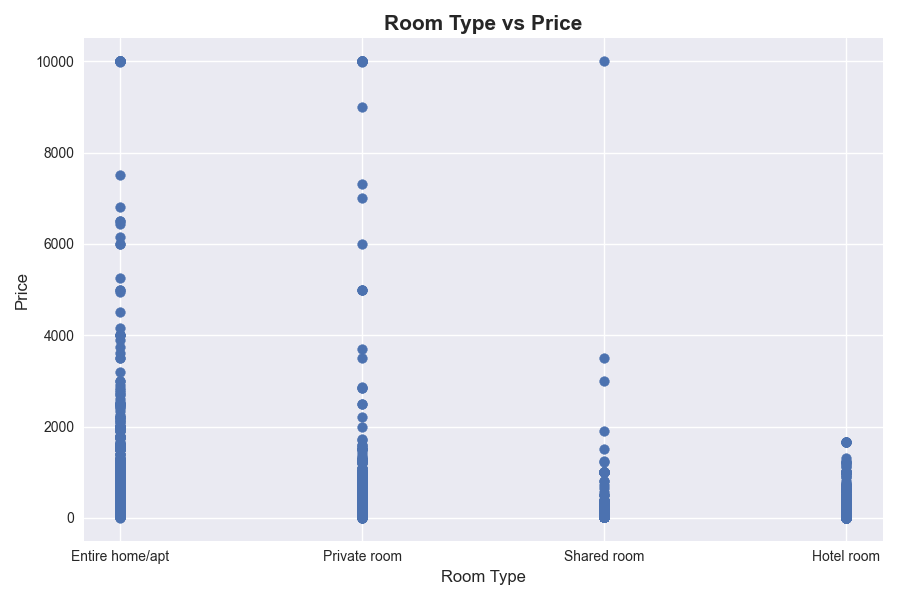

In [8]:
Draw_RoomType_vs_price()

As we can see from the scatter plot, "Hotel Room" is always less than $2000. Also, ther's an outlier in "Shared Room". Meanwhile, "Entrie Home/Apt" and "Private Room" have highest price in some.

Since the dataset has "neighbourhood_group" attribute, it is necessary to see the relationship with price as well.

In [9]:
def Draw_RoomTypeGrp_vs_price():
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x="room_type", y="price", 
                    hue="neighbourhood_group", size="neighbourhood_group",
                    sizes=(11, 50), palette="Dark2", data=df)

    plt.title("Room Type vs Price vs Neighbourhood Grouping",size=15, weight='bold')
    plt.xlabel("Room Type", size=12)
    plt.ylabel("Price", size=12)
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


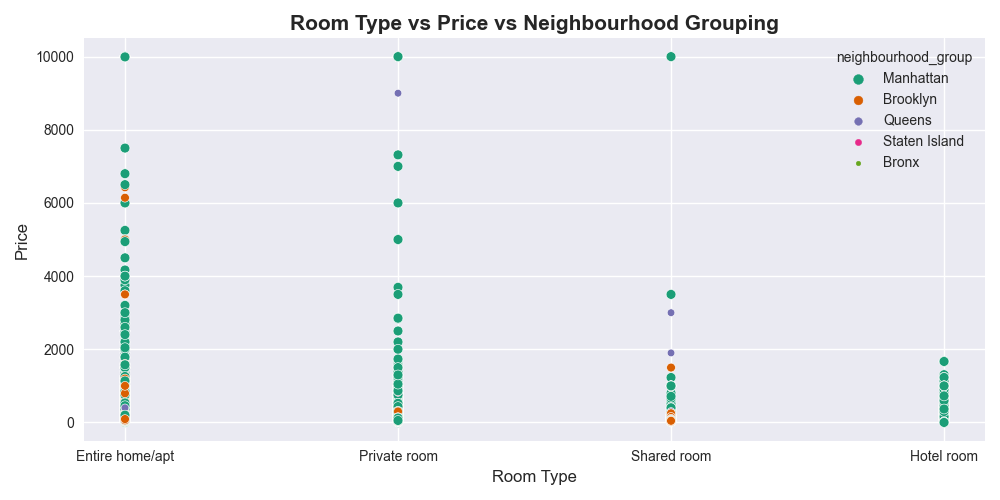

In [10]:
Draw_RoomTypeGrp_vs_price()

Based on the grpah above, Manhattan is the Neighbourhood with the highest price in all root types. However, all of "Hotel Room" in Manhattan are less than $2000. Meanwhile, Brooklyn has very high price in "Entire home/apt" and "Shared Room". On the other hand, Queens has the highest price in "Private Room".

Now since the "neighbourhood_group", "neighbourhood", and "room_type" have fixed categories, we can convert these attributes to categories. This will make the analysis much easier.

In [13]:
df['neighbourhood_group'].value_counts()

Manhattan        19741
Brooklyn         17851
Queens            5602
Bronx             1158
Staten Island      314
Name: neighbourhood_group, dtype: int64

In [14]:
df['neighbourhood'].value_counts()

Williamsburg          3302
Bedford-Stuyvesant    3291
Harlem                2451
Bushwick              2124
Hell's Kitchen        1782
                      ... 
Gerritsen Beach          1
Rossville                1
Fort Wadsworth           1
Tottenville              1
Huguenot                 1
Name: neighbourhood, Length: 221, dtype: int64

In [15]:
df['room_type'].value_counts()

Entire home/apt    22860
Private room       20498
Shared room          920
Hotel room           388
Name: room_type, dtype: int64

In [16]:
df['neighbourhood_group'] = df['neighbourhood_group'].astype("category").cat.codes
df['neighbourhood'] = df['neighbourhood'].astype("category").cat.codes
df['room_type'] = df['room_type'].astype("category").cat.codes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44666 entries, 0 to 44665
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              44666 non-null  int64  
 1   name                            44650 non-null  object 
 2   host_id                         44666 non-null  int64  
 3   host_name                       44649 non-null  object 
 4   neighbourhood_group             44666 non-null  int8   
 5   neighbourhood                   44666 non-null  int16  
 6   latitude                        44666 non-null  float64
 7   longitude                       44666 non-null  float64
 8   room_type                       44666 non-null  int8   
 9   price                           44666 non-null  int64  
 10  minimum_nights                  44666 non-null  int64  
 11  number_of_reviews               44666 non-null  int64  
 12  last_review                     

<IPython.core.display.Javascript object>


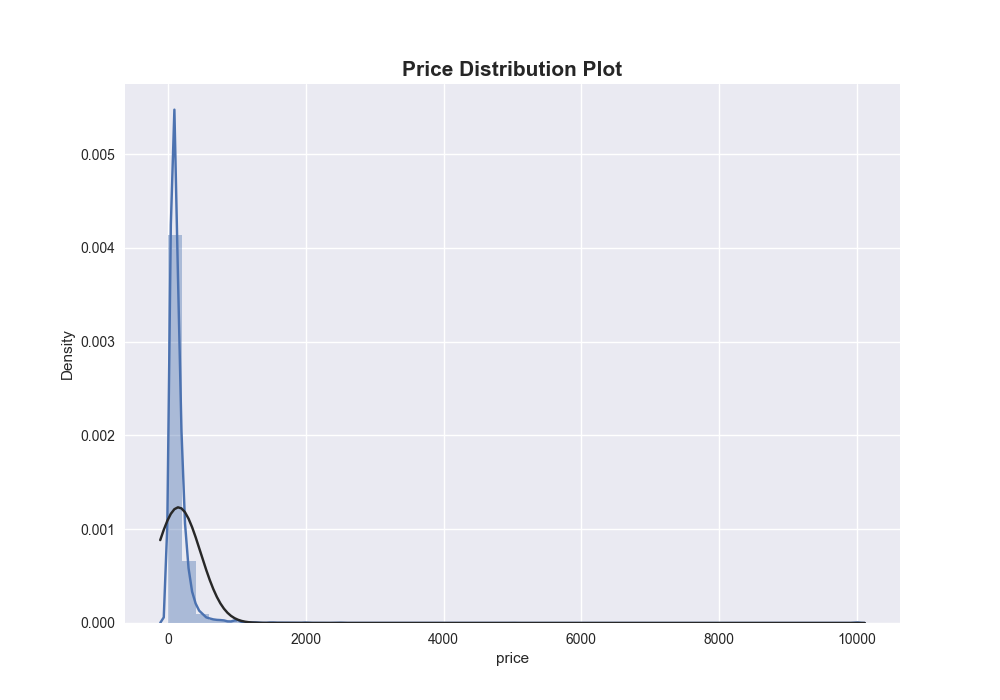

Text(0.5, 1.0, 'Price Distribution Plot')

In [60]:
plt.figure(figsize=(10, 7))
sns.distplot(df['price'], fit=norm, kde=True)

# newer version use this method to demonstrate the data
# sns.displot(df['price'], hue_norm=norm, kde=True, height=8, aspect=15/5)

plt.title("Price Distribution Plot", size=15, weight='bold')

In [23]:
print("The variance of price attribute: %s" % df['price'].var())

The variance of price attribute: 104566.06658060214


As we can see from the graph above, the distribution in price attribute is right skewed (aka positive skew). Therefore, we need to re-scaling/ normalize the data by apply log normalization to price attribute in order to make analysis easier.

As we can see from above graph, the value starts zero. Since we can't log zero, mathematically, therefore, we can use log + 1 to do the re-scaling/ log normalization.

In [48]:
df['price_log'] = np.log(df.price + 1)

In [49]:
print("The variance of log price attribute: %s" % df['price_log'].var())

The variance of log price attribute: 0.5223320890988663


As we can see, after we apply log normalization, the price attribute is less disperse

<IPython.core.display.Javascript object>


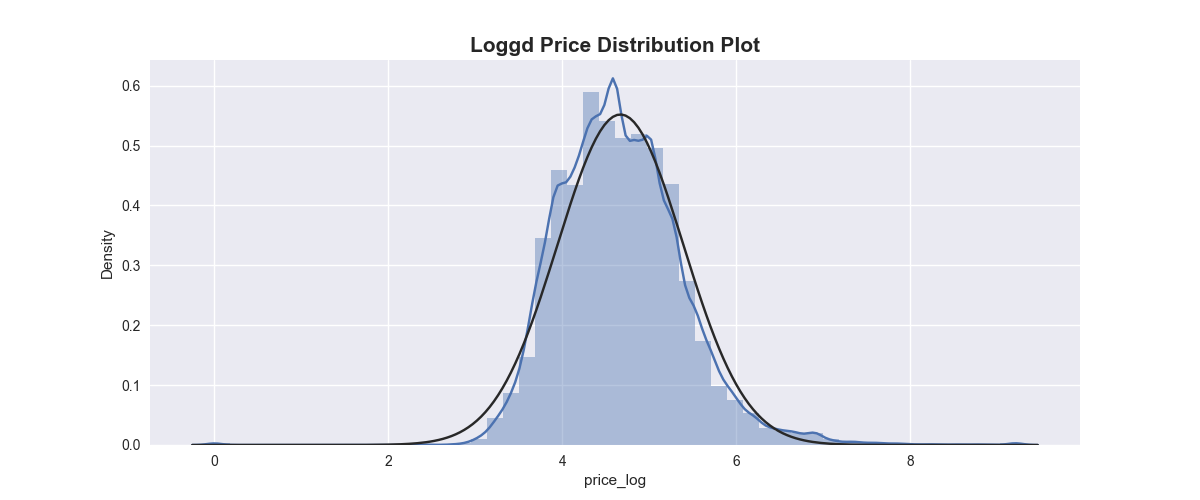

Text(0.5, 1.0, 'Loggd Price Distribution Plot')

In [61]:
plt.figure(figsize=(12, 5))
sns.distplot(df['price_log'], fit=norm, kde=True)

# newer version use this method to demonstrate the data
# sns.displot(df['price_log'], hue_norm=norm, kde=True, height=8, aspect=12/5)

plt.title("Loggd Price Distribution Plot",size=15, weight='bold')

As we can see from the above graph, price attribute is normal distrbute

<IPython.core.display.Javascript object>


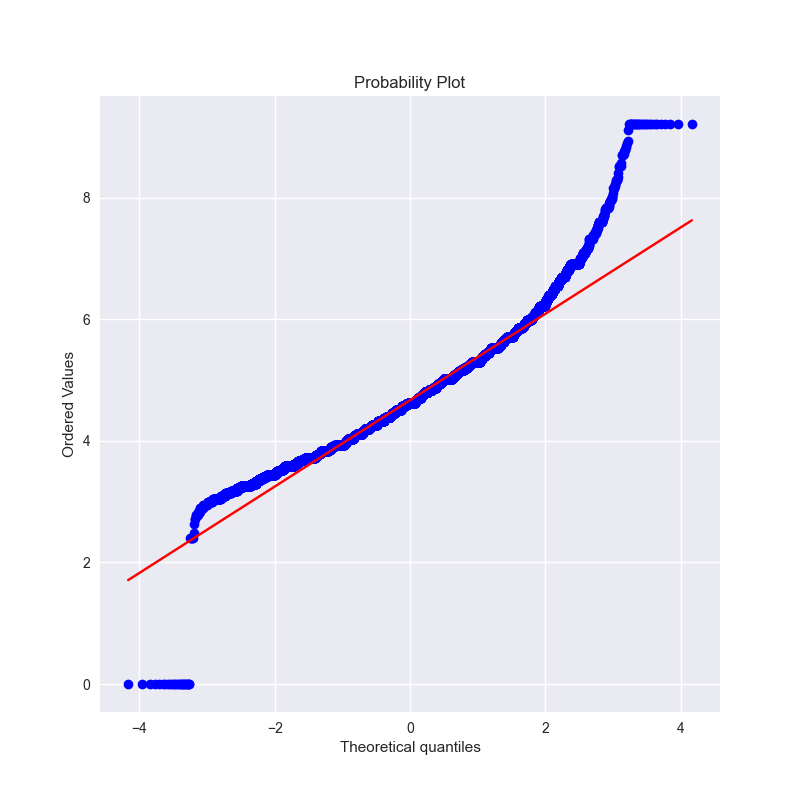

In [62]:
plt.figure(figsize=(8, 8))
stats.probplot(df['price_log'], plot=plt)
plt.show()

Prepare the data for the model

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44666 entries, 0 to 44665
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              44666 non-null  int64  
 1   name                            44650 non-null  object 
 2   host_id                         44666 non-null  int64  
 3   host_name                       44649 non-null  object 
 4   neighbourhood_group             44666 non-null  int8   
 5   neighbourhood                   44666 non-null  int16  
 6   latitude                        44666 non-null  float64
 7   longitude                       44666 non-null  float64
 8   room_type                       44666 non-null  int8   
 9   price                           44666 non-null  int64  
 10  minimum_nights                  44666 non-null  int64  
 11  number_of_reviews               44666 non-null  int64  
 12  last_review                     

As we can see from the above dataset info, we can drop useless attributes (non-nomincal type), such as id, name, host_id, host_name, last_review, price (old).

The normalization is reasonable since it covers most the plot in the graph. 

In [64]:
model = df.drop(columns=['name','id' ,'host_id','host_name', 'last_review','price'])

In [65]:
model.head(5)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_log
0,2,127,40.75362,-73.98377,0,3,48,0.36,2,365,5.170484
1,1,40,40.68514,-73.95976,0,1,354,4.82,1,2,4.343805
2,1,12,40.68688,-73.95596,2,29,50,0.36,1,2,4.110874
3,1,190,40.66120,-73.99423,0,7,1,0.01,1,359,5.170484
4,2,95,40.76489,-73.98493,2,2,473,3.40,1,350,4.304065


Now let's check the missing value of this model

In [66]:
def Find_MissingVal():
    # check the missing val
    missing_values_count = model.isnull().sum()
    total_cells = np.product(model.shape)
    total_missing = missing_values_count.sum()

    # percent of data that is missing
    percent_missing = (total_missing/ total_cells) * 100
    print("Missing values is: ", percent_missing, "%")

In [67]:
Find_MissingVal()

Missing values is:  2.1405339835465655 %


We have around 2.14% of missing value in this model. Let's see which one is missing.

In [68]:
model.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10517
calculated_host_listings_count        0
availability_365                      0
price_log                             0
dtype: int64

In [69]:
model['reviews_per_month']

0        0.36
1        4.82
2        0.36
3        0.01
4        3.40
         ... 
44661     NaN
44662     NaN
44663     NaN
44664     NaN
44665     NaN
Name: reviews_per_month, Length: 44666, dtype: float64

In this part, I will use mean of the attribute to replace the missing value since 'reviews_per_month' attribute is more symmetric.

In [74]:
model_mean = model['reviews_per_month'].mean()
model['reviews_per_month'].fillna(model_mean, inplace=True)
model.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
price_log                         0
dtype: int64

<IPython.core.display.Javascript object>


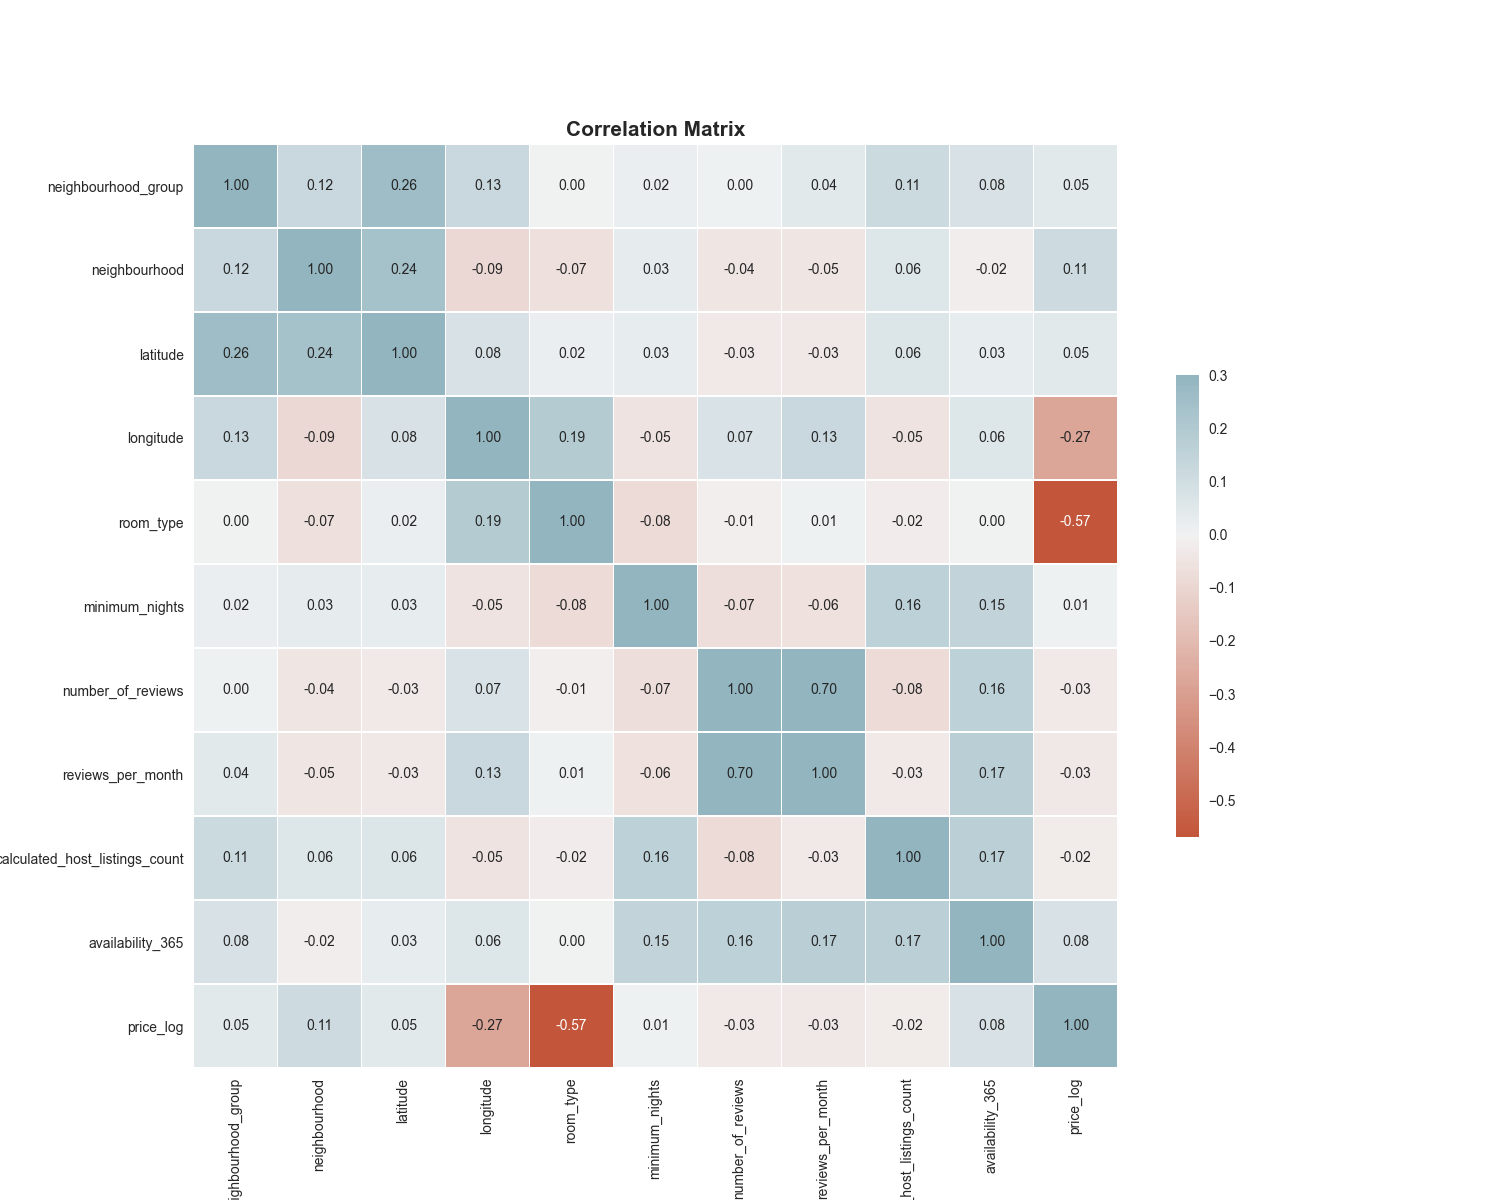

Text(0.5, 1.0, 'Correlation Matrix')

In [76]:
plt.figure(figsize=(15,12))

palette = sns.diverging_palette(20, 220, n=256)

corr=model.corr(method='pearson')

sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, 
            vmax=.3, center=0, square=True, linewidths=.5, 
            cbar_kws={"shrink": .5}).set(ylim=(11, 0))

plt.title("Correlation Matrix",size=15, weight='bold')

Note for reading correlation matrix:
1. The red boxes represent variables that have a negative relationship.
2. The blue boxes represent variables that have a positive relationship

The above Correlation Matrix uses Pearson method, which is commonly used in linear regression.
Formula:

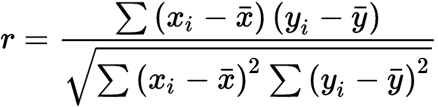


- r = correlation coefficient
- xi = values of the x-variable (attibute) in a sample (dataset)
- bar(x)  = mean of the values of the x-variable (of attribute)
- yi = values of the y-variable in a sample
- bar(y) = mean of the values of the y-variable


As we can see from the correlation matrix (CM), the attributes are diagonal correlated to themselves.

#### Strong Positive Relationship:
* "review_per_month" and "number_of_reviews", which means the higher "number_of_reviews" it get, the higher review per month it will get.

#### String Negative Relationship:
* "price" and "room_type", which means higher room price, the lower option of room type to choose.

#### Ref:
1. https://www.displayr.com/what-is-a-correlation-matrix/
2. https://www.graphpad.com/support/faq/what-is-the-difference-between-correlation-and-linear-regression/
3. https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/

Select feature from the model by using Standard Scaler technique to normalize the data set. In that way, each feature has 0 mean and 1 standard deviation.

"Standardize features by removing the mean and scaling to unit variance."

#### Ref:
1. https://docs.microsoft.com/en-us/analysis-services/data-mining/feature-selection-data-mining?view=asallproducts-allversions
2. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [124]:
model_x = model.iloc[:, :-1]
model_y = model.iloc[:, -1]

In [125]:
scaler = StandardScaler()
model_x_transformed = scaler.fit_transform(model_x)

Split the dataset into training and test set with ration of 70 and 30.

In [126]:
trainSet_x, testSet_x, trainSet_y, testSet_y = train_test_split(model_x, model_y, test_size=0.3, random_state=42)

In [127]:
# a snapshot of training set x
trainSet_x

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
38514,2,145,40.72349,-73.99413,0,1,0,0.864005,1,0
14921,3,53,40.77316,-73.91566,2,2,10,0.590000,2,88
40861,0,15,40.85373,-73.89374,2,30,10,2.170000,2,365
22807,1,85,40.67968,-73.99066,2,2,75,2.420000,1,0
42664,1,214,40.70480,-73.93492,0,14,0,0.864005,2,173
...,...,...,...,...,...,...,...,...,...,...
6265,2,63,40.72753,-73.98749,2,1,1,0.020000,1,0
11284,2,119,40.71823,-73.98319,2,7,0,0.864005,1,0
38158,3,105,40.68464,-73.80364,0,1,26,2.700000,1,0
860,1,190,40.63970,-74.01620,2,7,29,0.280000,2,348


In [128]:
# Linear Regression Func:

def linear_reg(input_x, input_y, cv=5):
    ## Defining parameters
    model_LR= LinearRegression()

    parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.
    grid_search_LR = GridSearchCV(estimator = model_LR,  
                         param_grid = parameters,
                         scoring = 'neg_mean_squared_error',
                         cv = cv,
                         n_jobs = -1)

    ## Lastly, finding the best parameters.
    grid_search_LR.fit(input_x, input_y)
    best_parameters_LR = grid_search_LR.best_params_  
    best_score_LR = grid_search_LR.best_score_ 
    print(best_parameters_LR)
    print(best_score_LR)

In [129]:
linear_reg(model_x, model_y)

{'copy_X': True, 'fit_intercept': True, 'normalize': False}
-0.330479708771768


In [130]:
LR = LinearRegression(copy_X= True, fit_intercept = True, normalize = True)
LR.fit(trainSet_x, trainSet_y)
LR_pred= LR.predict(testSet_x)

In [131]:
df2 = pd.DataFrame()
df2['data'] = LR_pred

In [132]:
df2

,data
0,5.032091
1,5.055046
2,4.230776
3,5.112624
4,5.246944
...,...
13395,5.136017
13396,5.138137
13397,4.064645
13398,4.287543


#### Without all features
by removing "neighbourhood_group" and "room_type" attribute

The steps are the exactly the same as with all fetures.

In [133]:
model_x2 = model.drop(columns=['neighbourhood_group', 'room_type'])

In [134]:
model_x2 = model_x2.iloc[:,:-1]
model_y2 = model_x2.iloc[:,-1]

Same thing here, we split the dataset into ratio of 70 and 30.

In [137]:
trainSet_x2, testSet_x2, trainSet_y2, testSet_y2 = train_test_split(model_x2, model_y2, test_size=0.3, random_state=42)

In [138]:
model_x2 = scaler.fit_transform(model_x2)

In [139]:
linear_reg(model_x2, model_y2, cv=4)

{'copy_X': True, 'fit_intercept': True, 'normalize': True}
-2.3489161936750194e-23


In [140]:
LR2 = LinearRegression(copy_X = True, fit_intercept = True, normalize = True)
LR2.fit(trainSet_x2, trainSet_y2)
LR2_pred_x= LR2.predict(testSet_x2)

#### Ref:
1. https://machinelearningmastery.com/polynomial-features-transforms-for-machine-learning/

In [145]:
Poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
trainSet_x = Poly.fit_transform(trainSet_x)
testSet_x = Poly.fit_transform(testSet_x)

In [147]:
print("With all features")
print('MAE: %f' % mean_absolute_error(testSet_y, LR))
print('RMSE: %f' % np.sqrt(mean_squared_error(testSet_y, LR)))   
print('R2 %f' % r2_score(testSet_y, LR))

print("")
print("Without all features")
print('MAE: %f' % mean_absolute_error(testSet_y2, LR2))
print('RMSE: %f' % np.sqrt(mean_squared_error(testSet_y2, LR2)))   
print('R2 %f' % r2_score(testSet_y2, LR2))

With all features


TypeError: Expected sequence or array-like, got <class 'sklearn.linear_model._base.LinearRegression'>